# 3D Code for finite electro-elasticity with u-p formulation.

Problem: Electro-elastic pull-in instability of a 3d VHB  block.

- with basic units:
    - Length: mm
    -  Time:  s
    -   Mass: kg
    - Charge: nC
- and derived units:
    - Pressure: kPa 
    - Force: milliNewtons
    - Electric potential: kV
    
Eric M. Stewart    and    Lallit Anand   
(ericstew@mit.edu)        (anand@mit.edu)   

 October 2023


In [1]:
import numpy as np


from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, FunctionSpace, Expression
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

import ufl
from ufl import (
    TestFunction,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    tanh,
    as_tensor,
    as_vector,
    ge
)

from dielectricmodels import DE_3D
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters
import random
import gmsh

In [2]:


with XDMFFile(MPI.COMM_WORLD,"meshes/gripper.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    ct = infile.read_meshtags(domain,name="Grid")
    
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

with XDMFFile(MPI.COMM_WORLD, "meshes/facet_gripper.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(domain, name="Grid")
    
problemName = "gripper"

In [3]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:58373/index.html?ui=P_0x293e86f10_0&reconnect=auto' style='width: …

In [4]:
#locate different boundaries
#left
tol = 1e-10
def Ground(x):
    return np.isclose(x[0], 0) & np.isclose(x[1], 0) & np.isclose(x[2], 0)


def ZFix(x):
    return np.isclose(x[2], .5) & (x[0] <= 10) & (x[1] <= 10)

In [5]:
# Note the surface numbering, from the gmsh *.geo file:
# Physical Surface("Ztop", 72) = {8};
# Physical Surface("Zmid", 73) = {1};
# Physical Surface("Zbot", 74) = {15};
# Physical Surface("Xbot", 75) = {6,7,13,14};
# Physical Surface("Ybot", 76) = {4,5,11,12};

facet_indices, facet_markers = [], []
fdim = domain.topology.dim-1


facets = mesh.locate_entities_boundary(domain, fdim, ZFix)
facet_indices.append(facets)
facet_markers.append(np.full_like(facets, 1))



facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)


# Simulation Control

In [6]:
phitot = 4.4# kV
t      = 0.0                  # start time (s)
freq   = 1                    # frequency in Hz, cycles/s
omega  = 2.*np.pi*freq        # angular frequency radians/s
ncycles= 1                    # number of cycles
Ttot   = ncycles/freq         # total time
numSteps = 100
dt = Ttot / numSteps
dk = Constant(domain,dt)  # (fixed) step size

In [7]:
DE_prob = DE_3D(domain,phiTot =  phitot)
DE_prob.Kinematics()
DE_prob.WeakForms(dk)
DE_prob.vareps_r.value=5

In [8]:
DE_prob.phiTot

4.4

In [9]:
def muAmp(t):
    return phitot*np.sin(omega*t)

In [10]:
Time_cons = Constant(domain,PETSc.ScalarType(muAmp(t)))

#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))
V0, submap = DE_prob.ME.sub(0).collapse()
fixed_displacement = fem.Function(V0)
fixed_displacement.interpolate(lambda x: np.stack((np.zeros(x.shape[1]), np.zeros(x.shape[1]), np.zeros(x.shape[1]))))

dofs_1 = fem.locate_dofs_topological((DE_prob.ME.sub(0),V0), facet_tag.dim, facet_tag.find(1))
dofs_2 = fem.locate_dofs_topological(DE_prob.ME.sub(2), ft.dim, ft.find(73))
dofs_3 = fem.locate_dofs_topological(DE_prob.ME.sub(2), ft.dim, ft.find(72))

dofs_4 = fem.locate_dofs_topological(DE_prob.ME.sub(0).sub(0), ft.dim, ft.find(75))
dofs_5 = fem.locate_dofs_topological(DE_prob.ME.sub(0).sub(1), ft.dim, ft.find(76))


bcs_1 = dirichletbc(fixed_displacement, dofs_1,DE_prob.ME.sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, dofs_2, DE_prob.ME.sub(2))  # u2 fix - yBot
bcs_3 = dirichletbc(Time_cons, dofs_3, DE_prob.ME.sub(2))  # u2 fix - yBot

bcs_4 = dirichletbc(0.0,dofs_4 ,DE_prob.ME.sub(0).sub(0))  # u3 fix - zBot
bcs_5 = dirichletbc(0.0,dofs_5 ,DE_prob.ME.sub(0).sub(1))  # u3 fix - zBot

#
bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

# Set Output File

In [11]:
import dolfinx
U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, DE_prob.P1)#Scalar function space

u_vis = Function(V2)
u_vis.name = "u"
u_expr = Expression(DE_prob.u,V2.element.interpolation_points())


p_vis = Function(V1)
p_vis.name = "p"
p_expr = Expression(DE_prob.p,V1.element.interpolation_points())

phi_Vis = Function(V1)
phi_Vis.name = "phi"
phi_expr = Expression(DE_prob.phi,V1.element.interpolation_points())


T = DE_prob.Tmat *DE_prob.F.T/DE_prob.J#Cauchy Stress

T0 = T - (1 / 3) * tr(T) * Identity(3)
Mises = sqrt((3 / 2) * inner(T0, T0))




Mises_vis = Function(V1)
Mises_vis.name = "Mises"
mises_expr = Expression(Mises,V1.element.interpolation_points())

#vtk2 = VTXWriter(domain.comm,"results/"+problemName+"displacement.bp", [u_vis], engine="BP4" )

vtk = VTXWriter(domain.comm,"results/"+problemName+".bp", [u_vis,p_vis,phi_Vis,Mises_vis], engine="BP4" )

files = [vtk]

def interp_and_save(t, files: list[VTXWriter]):
    u_vis.interpolate(u_expr)
    p_vis.interpolate(p_expr)
    phi_Vis.interpolate(phi_expr)
    Mises_vis.interpolate(mises_expr)

    for file in files:
        file.write(t)
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)


voltagePoint = [0,0,.5]
cell_candidates_volt = dolfinx.geometry.compute_collisions_points(bb_tree, voltagePoint)
colliding_cells_volt = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates_volt, voltagePoint)

displacementPoint = [50,0,0]
cell_candidates_disp = dolfinx.geometry.compute_collisions_points(bb_tree, displacementPoint)
colliding_cells_disp= dolfinx.geometry.compute_colliding_cells(domain, cell_candidates_disp, displacementPoint)
 
 

In [12]:
import os
step = "Swell"
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}

problem = NonlinearProblem(DE_prob.Res,DE_prob.w, bcs, DE_prob.a,jit_options=jit_options)

totSteps = numSteps + 1
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps])

solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 30
solver.report = True
solver.error_on_nonconvergence = False

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_max_it"] = 30
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

startTime = datetime.now()
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

step = "Actuate"

#if os.path.exists("results/"+problemName+".bp"):
#    os.remove("results/"+problemName+".xdmf")
#    os.remove("results/"+problemName+".h5")

#vtk.write_mesh(domain)
t = 0.0
#log.set_log_level(log.LogLevel.INFO)
interp_and_save(t, files)
ii = 0
bisection_count = 0
totSteps = numSteps + 1

timeHist0 = np.zeros(shape=[100000])
timeHist1 = np.zeros(shape=[100000]) 
timeHist2 = np.zeros(shape=[100000]) 

while round(t + dt, 9) <= Ttot:
    # increment time
    t += float(dt) 
    # increment counter
    ii +=1
    Time_cons.value = muAmp(t)
    print(muAmp(t))
    

    # Solve the problem
    
    (iter, converged) = solver.solve(DE_prob.w)
    
    if converged:
        DE_prob.w.x.scatter_forward()
        DE_prob.w_old.x.array[:] = DE_prob.w.x.array
        
        timeHist0[ii] = t
        timeHist2[ii] = DE_prob.w.sub(0).sub(2).eval(displacementPoint,colliding_cells_disp[0])[0]
        timeHist1[ii] = DE_prob.w.sub(2).eval(voltagePoint,colliding_cells_volt[0])[0]  # time history of voltage phi
        
        interp_and_save(t, files)
        
        if ii % 1 == 0:
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
           
            
            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print(f"Simulation Time: {t:.2f} s | dt: {float(dt):.4f}s")
            print()
        #Reset Biseciton Counter
        bisection_count = 0
        
                # Iteration-based adaptive time-stepping
        #
        # If the newton solver takes 3 or less iterations, 
        # increase the time step by a factor of 1.5:
        if iter<=3:
            dt = 1.5*dt
            dk.value = dt
        # If the newton solver takes 5 or more iterations, 
        # decrease the time step by a factor of 2:
        elif iter>=10:
            dt = dt/2
            dk.value = dt
        # otherwise the newton solver took 3-4 iterations,
        # in which case leave the time step alone.
        
    else:
        
        print( "Error Halfing Time Step")
        
         # first, we back up in time
        # ( to un-do the current time step )
        t = t - float(dk)
        
        # Then, we cut back on the time step we're attempting.
        # (by a factor of 2)
        dt = dt/2
        dk.value = dt
        
        # Finally, we have to reset the degrees of freedom to their
        # "old" values before trying to solve again, otherwise the 
        # initial guess for w is retained from the "failed" solve attempt.
        DE_prob.w.vector()[:] = DE_prob.w_old.vector()
        break
        

#End Analysis

for file in files:
    file.close()
endTime = datetime.now()
print("------------------------------------")
print("Simulation End")
print("------------------------------------")
print("Total Time: {}".format(endTime - startTime))
print("------------------------------------")

------------------------------------
Simulation Start
------------------------------------
0.27627828592897885
Step: Actuate |   Increment: 1 | Iterations: 5
Simulation Time: 0.01 s | dt: 0.0100s

0.5514662276829387
Step: Actuate |   Increment: 2 | Iterations: 6
Simulation Time: 0.02 s | dt: 0.0100s

0.8244777841771883
Step: Actuate |   Increment: 3 | Iterations: 6
Simulation Time: 0.03 s | dt: 0.0100s

1.0942355035253613
Step: Actuate |   Increment: 4 | Iterations: 6
Simulation Time: 0.04 s | dt: 0.0100s

1.3596747752497687
Step: Actuate |   Increment: 5 | Iterations: 6
Simulation Time: 0.05 s | dt: 0.0100s

1.6197480318125832
Step: Actuate |   Increment: 6 | Iterations: 6
Simulation Time: 0.06 s | dt: 0.0100s

1.8734288828863201
Step: Actuate |   Increment: 7 | Iterations: 6
Simulation Time: 0.07 s | dt: 0.0100s

2.1197161660475476
Step: Actuate |   Increment: 8 | Iterations: 7
Simulation Time: 0.08 s | dt: 0.0100s

2.3576378979075856
Step: Actuate |   Increment: 9 | Iterations: 7
Si

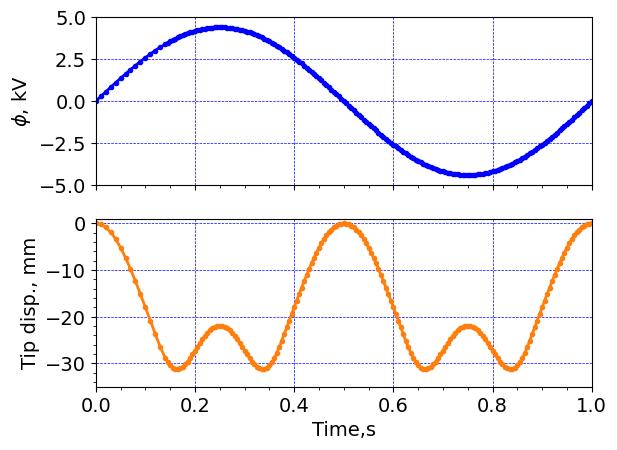

<Figure size 600x400 with 0 Axes>

In [13]:
"""""" """""" """""" """
    VISUALIZATION
""" """""" """""" """"""
import matplotlib.pyplot as plt

## set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Only plot as far as we have history data
ind = np.argmax(timeHist0) +1

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#------------------------------------------------------------------------------
# multi-plot figure
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')
 
#---------------- Voltage vs time plot
Volts = timeHist1
color = 'blue'
ax1.set_ylabel(r'$\phi$, kV')
ax1.set_ylim(-5, 5)
ax1.grid(linestyle="--", linewidth=0.5, color='b')
#
ax1.plot(timeHist0[0:ind],Volts[0:ind],  color=color, linewidth=2.0, marker='.')

#---------------- Tip displacement versus time plot
Displacement = timeHist2
color = 'red'
ax2.set_ylabel(r'Tip disp., mm')
ax2.set_ylim(-35, 1.0)
ax2.grid(linestyle="--", linewidth=0.5, color='b')
#
ax2.plot(timeHist0[0:ind], Displacement[0:ind],  c=colors[1],\
         linewidth=2.0, marker='.')

ax2.set_xlim(0, 1)
ax2.set_xlabel(r"Time,s")

from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()

# save figure to file
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout()

plt.savefig("results/"+problemName+".png", dpi=600)